#Part 1

## Question 1

In [ ]:
%matplotlib inline
%pylab inline

import os
import numpy as np
import numpy.linalg as LA
from google.colab import drive
from PIL import Image
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn import metrics, svm
from sklearn.svm import SVR
from sklearn.metrics import classification_report, confusion_matrix

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

!pip install python-resize-image
from resizeimage import resizeimage

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Import images from google drive

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DI/images/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
def loadImages(path):

  arr = list()
  labels = list()

  for filename in os.listdir(path):

    if filename[0]=="W":
      labels.append(0)
    elif filename[0]=="F":
      labels.append(1)
    else:
      labels.append(2)

    with open(path + '/' + filename, 'r+b') as f:
      with Image.open(f) as image:

        cover = resizeimage.resize_cover(image, [100, 100])
        cover.save(path + '/' + filename, image.format)

        # convert image to numpy array
        data = np.asarray(cover)

        actual = data.reshape(30000, 1)

        arr.append(actual)

  return np.array(arr).T, labels

Data and labels. Labels are 0 for winter, 1 for autumn and 2 for spring

In [ ]:
imAr, labels = loadImages(base_dir)

imAr = imAr.reshape(30000, 30)
print("Image labels are:", labels)

print("type(imAr)", type(imAr))
print("imAr.shape", imAr.shape)

print(imAr[:5])

Image labels are: [1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 2, 2, 2, 1, 0, 1, 0, 2, 0, 2, 2, 1, 2, 0, 0, 1, 1, 1]
type(imAr) <class 'numpy.ndarray'>
imAr.shape (30000, 30)
[[174  57  50 139 132   0  58  80  49  68 134 188 171  66   2  27 156  76
  245  56 152  18 137 145   0  46  67  61  58  85]
 [140  63  66 143  44   1  78  81  51  68 141 202 232  50   3  16 153  39
  241  65 152   2 138 110   0  59  61  88  26  65]
 [157  35  82 144   0   0 115  83  64  78 149 211 255  34   7  32 146  20
  230  60 164  12  78  88   9  78  63 105  11   2]
 [151  64  94 166 195   2  83  76  83  76 116 200 183  65   2  28 184  61
  239  58 121  20  96 134   9  59  86  69  64  99]
 [121  70 110 170 115   4 105  79  87  76 123 215 233  50   3  15 181  25
  235  68 121   2  99 100  12  72  80  95  33  79]]


Dimensions of all images must change to 100 * 100 pixels

In [ ]:
for filename in os.listdir(base_dir):
  image = Image.open(base_dir + '/' + filename)
  print(filename,"has size", image.size)  # size in pixels as a 2-tuple (width, height)

F10.jpg has size (100, 100)
S9.jpg has size (100, 100)
W4.jpg has size (100, 100)
W2.jpg has size (100, 100)
F9.jpg has size (100, 100)
S3.jpg has size (100, 100)
F8.jpg has size (100, 100)
S10.jpg has size (100, 100)
F4.jpg has size (100, 100)
W9.jpg has size (100, 100)
W6.jpg has size (100, 100)
W5.jpg has size (100, 100)
S4.jpg has size (100, 100)
S2.jpg has size (100, 100)
S7.jpg has size (100, 100)
F3.jpg has size (100, 100)
W3.jpg has size (100, 100)
F7.jpg has size (100, 100)
W7.jpg has size (100, 100)
S8.jpg has size (100, 100)
W1.jpg has size (100, 100)
S5.jpg has size (100, 100)
S6.jpg has size (100, 100)
F5.jpg has size (100, 100)
S1.jpg has size (100, 100)
W8.jpg has size (100, 100)
W10.jpg has size (100, 100)
F6.jpg has size (100, 100)
F2.jpg has size (100, 100)
F1.jpg has size (100, 100)


## Question 2

In [ ]:
def plotImage(x, y, ax, rIm):
  bb = Bbox.from_bounds(x,y,30,30)  
  bb2 = TransformedBbox(bb,ax.transData)
  bbox_image = BboxImage(bb2,
                      norm = None,
                      origin=None,
                      clip_on=False)

  bbox_image.set_data(rIm)
  ax.add_artist(bbox_image)


def PCADF(df, comps):  # takes a dataframe and return another with the pca values
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  # make list of col names
  nAms = list()
  for i in range(comps):
    nAms.append("PC"+str(i+1))

  pca = PCA(n_components=comps)
  principalComponents = pca.fit_transform(df.values)
  principalDf = pd.DataFrame(data = principalComponents, columns = nAms)
  
  return principalDf


def PCA_ImageSpaceVisualization(X): # X is the data array

  df = pd.DataFrame(data=X)         # convert to dataframe
  df = df.T

  principalDf = PCADF(df, 2)

  fig = plt.figure(figsize = (15,15))
  ax = fig.add_subplot(111)
  ax.set_xlabel('Principal Component 1', fontsize = 15)
  ax.set_ylabel('Principal Component 2', fontsize = 15)
  ax.set_title('2 component PCA', fontsize = 20)

  for x, y, im in zip(principalDf["PC1"], principalDf["PC2"], X.T):
    img = Image.fromarray(im.reshape((100, 100, 3)), 'RGB')
    plotImage(x, y, ax, img)

  ax.set_ylim(-200,200)
  ax.set_xlim(-200,250)
  ax.grid()

  return

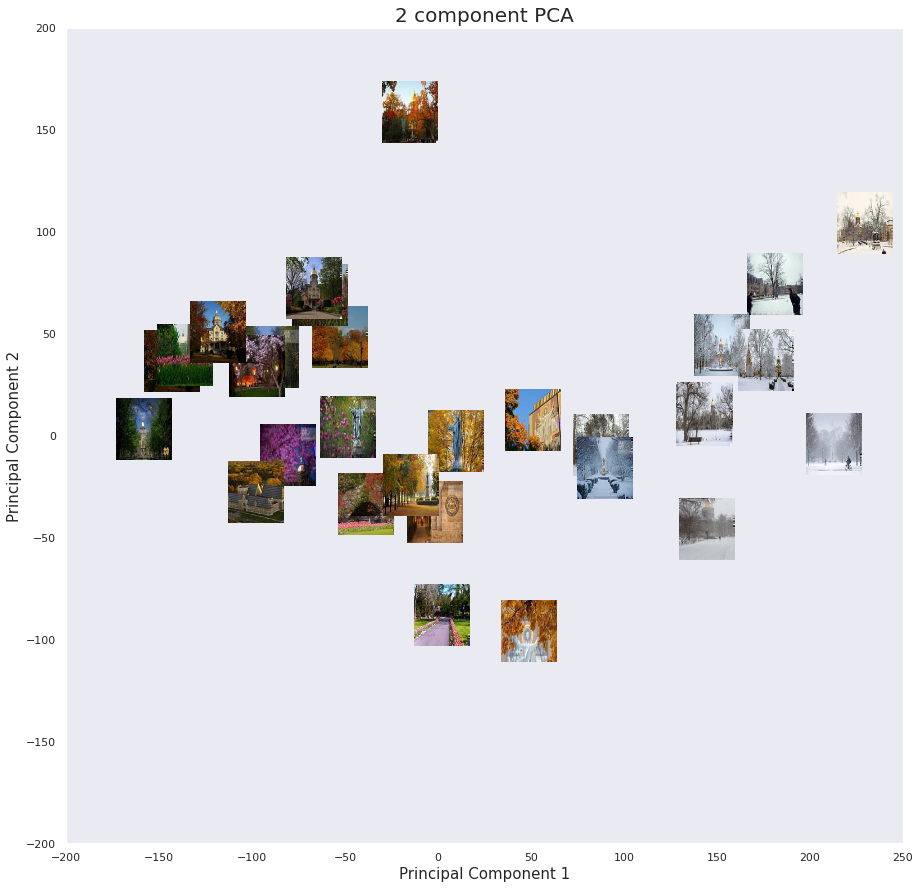

In [ ]:
PCA_ImageSpaceVisualization(imAr)

##### 2.1
PCA is a dimensionality-reduction method that only uses the most important features of the data to compare them easily and quickly and to make it easier to visualize them.
 The closer two images are to each other in the plot, the more identical they are based on the first two main components, while the farther away they are, the less identical they are.
These conclusions are also generalized for the large initial feature space of the images.
Applying PCA does not alter the characteristics of the data, but only presents them more simply.
If we made a similar comparison using all the original features we would have the same and perhaps clearer results with the difference that more extensive and slower processing would be required.

##### 2.2
The winter images are grouped closer to each other and can be easily distinguished in comparison with the images of the other two seasons which are to some extent mixed. This clear grouping of winter images occurs due to their color shades that make them stand out from the spring and autumn ones. They have more gray, white and hazy colors that differentiate them from the other two categories.

## Question 3

In [ ]:
def splitData(data, labels, t_size):
  # Split dataset into training set and test set
  return train_test_split(data, labels, test_size=t_size, random_state=109)

def crossValS(data, labels, best_svr):
  print("5-fold cross validation")

  scores = []
  labelAr = numpy.array(labels)
  cv = KFold(n_splits=5, shuffle=False)
  for train_index, test_index in cv.split(data):

      X_train, X_test, y_train, y_test = data[train_index], data[test_index], labelAr[train_index], labelAr[test_index]
      best_svr.fit(X_train, y_train)
      scores.append(best_svr.score(X_test, y_test))

  print("Mean Score:", np.mean(scores))
  print("cross_val_score", cross_val_score(best_svr, data, labels, cv=5))

def K1NN(data, labels, X_train, X_test, y_train, y_test):

  knn = KNeighborsClassifier(n_neighbors=1, weights='distance')

  #Train the model using the training sets
  knn.fit(X_train, y_train)

  #Predict the response for test dataset
  y_pred = knn.predict(X_test)

  # Model Accuracy, how often is the classifier correct?
  print("Classification Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Balanced Classification Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

  crossValS(data, labels, knn)

  return


def SVMclas(data, labels, X_train, X_test, y_train, y_test):

  clf = svm.SVC(kernel='linear', C=1.0) # Linear Kernel

  clf.fit(X_train, y_train)

  y_pred = clf.predict(X_test)

  print("Classification Accuracy:",metrics.accuracy_score(y_test, y_pred))
  print("Balanced Classification Accuracy:",metrics.balanced_accuracy_score(y_test, y_pred))

  crossValS(data, labels, clf)
  return

def PCADFWithComp(df):  # takes a dataframe and return another with the pca values
  scaled_features = StandardScaler().fit_transform(df.values)
  df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)

  n_components = 30 ## how may componets to compute
  pca = PCA(n_components=n_components, whiten=True).fit(df.values)
  components = pca.transform(df.values)
  
  cumExplainedVar=np.cumsum(pca.explained_variance_ratio_)

  plt.figure(figsize=(10, 10))
  numOfComp=10
  plt.subplot(2, 2, 1)
  plt.bar(range(numOfComp),pca.explained_variance_ratio_[:numOfComp])
  plt.xlabel(' components ')
  plt.ylabel(' explained variance');

  plt.subplot(2, 2, 2)
  plt.plot(cumExplainedVar[:10])
  plt.xlabel('number of components retained (10 first)')
  plt.ylabel('cumulative explained variance');

  plt.subplot(2, 2, 3)
  plt.plot(cumExplainedVar[:20])
  plt.xlabel('number of components retained (20 first)')
  plt.ylabel('cumulative explained variance');

  plt.subplot(2, 2, 4)
  plt.plot(cumExplainedVar)
  plt.xlabel('number of components retained (30)')
  plt.ylabel('cumulative explained variance');

  plt.show()

  return

Classification Accuracy:

$Accuracy=\frac{TP+TN}{TP+FP+TN+FN}$

where:<br>
TP = True Positive<br>
TN = True Negative<br>
FP = False Positive<br>
FP = False Negative<br>

In each of the following fields the methods for the different data types are executed (1-NN and SVM for the initial full-scale vector-formatted images and for the low-dimensional features exported via PCA). Classification Accuracy (3.1) is calculated and 5-fold cross validation (3.2) is executed.

(3.3)<br>
The ability to estimate the dimension of the characteristics we export is very important for the proper use of PCA. This can be determined by examining the cumulative ratio of the variance in relation to the number of main components.

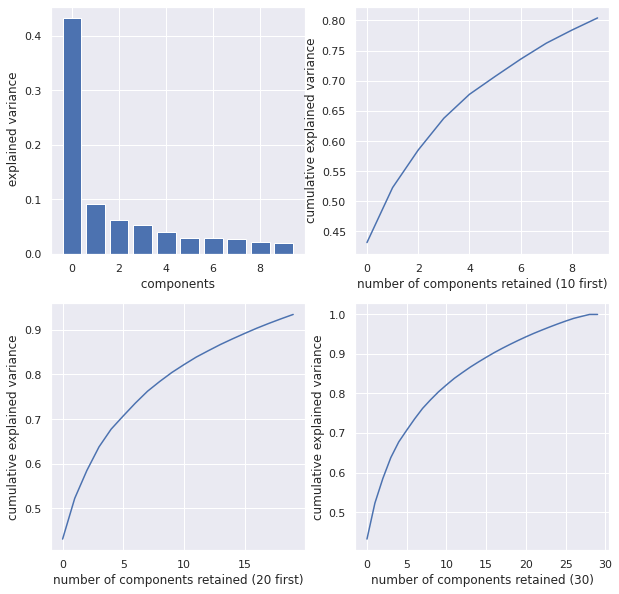

In [ ]:
df = pd.DataFrame(data=imAr)
df = df.T

PCADFWithComp(df)

We observe that the first two components explain about 58% of the data fluctuation while for the 90% we need about 16 components. Below we analyze the data in the first 10 components, a number that is large enough to have a good description of the data and small enough that the calculations are not time consuming.

1-NN on vector-formatted large dimension images.

In [ ]:
tmp = imAr.T

X_train, X_test, y_train, y_test = splitData(tmp, labels, 0.3)

K1NN(tmp, labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.7777777777777778
Balanced Classification Accuracy: 0.7222222222222222
5-fold cross validation
Mean Score: 0.8333333333333333
cross_val_score [0.83333333 0.5        0.83333333 0.83333333 1.        ]


1-NN on low dimensional characteristics via PCA

In [ ]:
principalDf = PCADF(df, 10)

X_train, X_test, y_train, y_test = splitData(principalDf.to_numpy(), labels, 0.3)

K1NN(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.7777777777777778
Balanced Classification Accuracy: 0.7222222222222222
5-fold cross validation
Mean Score: 0.6666666666666666
cross_val_score [0.83333333 0.5        0.66666667 0.83333333 0.66666667]


SVM on vector-formatted large dimension images.

In [ ]:
X_train, X_test, y_train, y_test = splitData(tmp, labels, 0.3)

SVMclas(tmp, labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.7777777777777778
Balanced Classification Accuracy: 0.7222222222222222
5-fold cross validation
Mean Score: 0.7666666666666667
cross_val_score [0.83333333 0.66666667 0.83333333 0.83333333 1.        ]


SVM on low dimensional characteristics via PCA

In [ ]:
X_train, X_test, y_train, y_test = splitData(principalDf.to_numpy(), labels, 0.3)

SVMclas(principalDf.to_numpy(), labels, X_train, X_test, y_train, y_test)

Classification Accuracy: 0.7777777777777778
Balanced Classification Accuracy: 0.7222222222222222
5-fold cross validation
Mean Score: 0.7666666666666667
cross_val_score [0.83333333 0.83333333 0.66666667 0.83333333 0.66666667]


The SVM classifier has better performance as we see from the mean scores of cross validation and from the classification accuracy scores. This was expected, since the SVM calculates outliers better than the KNN, while the KNN is better than the SVM only if the amount of training data is much larger than the number of features.
<br>Source:
<br>https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222#:~:text=SVM%20take%20cares%20of%20outliers,features%20and%20lesser%20training%20data.

# Part 2

We study the optimization problem
<br><br>
$$\min_{W, C}∥X − WC∥^2_F + λ∥W∥^2_F + λ∥C∥^2_F s.t.W ≥ 0, C ≥ 0$$

Two ways to solve the problem were studied.
<br>
###First way, which is by far the most efficient:
<br>Taking into consideration that for the least squares problem discussed in course<br><br>
$$\min_{W,C} l(W,C) = ∥ X − WC ∥ _F^2 s.t.W ≥ 0, C ≥ 0 $$

we end up with the following parameter update formulas:<br><br>
$ C_{[t+1]} = C_{[t]} − n_t*∇_{C_{[t]}} l (W,C_{[t]}) $  
<br>
$ W_{[t+1]} = W_{[t]} − n_t*∇_{W_{[t]}} l (W_{[t]},C) $  
<br>
t = t + 1
<br>
or equivalently<br>
$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}^TX}{W_{[t]}^TW_{[t]}C_{[t]}} $  
<br>
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T}{W_{[t]}C_{[t]}C_{[t]}^T} $
<br>t = t + 1  

then, as it comes to the problem given, we end up with the following formulas based on the source https://stats.stackexchange.com/questions/351359/deriving-multiplicative-update-rules-for-nmf:<br><br>
$ C_{[t+1]} = C_{[t]} * \frac{W^TX} {W^TWC_{[t]} + λC_{[t]}} $  
<br>
$ W_{[t+1]} = W_{[t]} * \frac{XC^T} {W_{[t]}CC^T + λW_{[t]}} $
<br>
t = t + 1  
<br>
## Justification:  

$$\min_{W,C} l(W,C) = ∥ X − WC ∥ _F^2 s.t.W ≥ 0, C ≥ 0 $$
from $ ∥ X ∥ _F^2 = Tr(X^TX) $ we equivalently get<br><br>
$Tr((X-WC)^T(X-WC)) + λTr(W^TW) + λTr(C^TC) =$<br>  
$Tr(X^TX - X^TWC -C^TW^TX + C^TW^TWC) + λTr(W^TW) + λTr(C^TC)=$<br>
$Tr(X^T) - Tr(X^TWC) - Tr(C^TW^TX) + Tr(C^TW^TWC) + λTr(W^TW) + λTr(C^TC)$

<br>By derivation with respect to W we get:<br><br>
$ ∇_W Tr(X^T) - ∇_W Tr(X^TWC) - ∇_W Tr(C^TW^TX) + ∇_W Tr(C^TW^TWC) + ∇_W
λTr(W^TW) + ∇_W λTr(C^TC)$<br><br>

According to the properties:<br>
$ ∇_X Tr(AX) = A^T $<br>
$ ∇_X Tr(X^TA) = A $<br>
$ ∇_X Tr(XAA^TX^T) = X(A + A^T)$<br><br>

We calculate the derivatives:<br>
$ ∇_W Tr(X^TX) = 0$<br><br>
$ ∇_W Tr(X^TWC) = ∇_W Tr(CX^TW) = (CX^T)^T = XC^T$<br><br>
$ ∇_W Tr(C^TW^TX) = ∇_W Tr(XC^TW^T) = XC^T $<br><br>
$ ∇_W Tr(C^TW^TWC) = ∇_W Tr(WCC^TW^T) = W(CC^T + (CC^T)^T) = 2WCC^T$<br><br>
$ ∇_W λTr(W^TW) = ∇_W λTr(WIW^T) = λW(I + I^T) = 2λW$<br><br>
$ ∇_W λTr(C^TC) = 0 $<br><br>


So we conclude that<br><br>
$ ∇_W f(W,C) = 2WCC^T + 2λW - 2XC^T$<br><br>
Therefore<br><br>
$ W_{[t+1]} = W_{[t]} - n_t*∇_{W_{[t]}} l (W_{[t]},C)=$<br><br>
$W_{[t]} - n_t * (2W_{[t]}CC^T + 2λW_{[t]} - 2XC^T)$<br><br>

The constant 2 can be adjusted to the learning rate $ (n_t) $ and thus can be ignored at this point:<br><br>
$ W_{[t+1]} = W_{[t]} - n_t * (W_{[t+1]}CC^T - XC^T + λW_{[t+1]})$<br>
or equivalently<br><br>
$ W_{[t+1]} = W_{[t]} * \frac{XC^T} {W_{[t]}CC^T + λW_{[t]}}$<br><br>

Respectively, with derivative with respect to C we conclude that<br>
$ C_{[t+1]} = C_{[t]} * \frac{W^TX} {W^TWC_{[t]} + λC_{[t]}} $

To determine if the iterative algorithm converges to the optimal solution we monitor the reconstruction error
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F}{∥X∥^2_F}$ <br><br>

in each iteration and if its change between two consecutive iterations is less than a threshold $ε$
<br><br>$\frac{∥X − W_{[t]}C_{[t]}∥^2_F - ∥X − W_{[t-1]}C_{[t-1]}∥^2_F}{∥X∥^2_F} < ε$ <br><br>
with $ε$ = 0.01 or 0.001 or 0.0001 the algorithm is terminated. $t$ on the above relations symbolizes the iteration index.

In [ ]:
# W : matrix of basis vectors
# C : matrix of coefficients
# frob_error : frobenius norm
def frobenius_norm(X,W,C):
		#error between X and W*H
		error = LA.norm(X - np.dot(W, C))
		return error

def C_update(X, W, C, l):
  numerator = np.dot(W.T, X)
  denominator = np.dot(W.T, W.dot(C)) + l*C
  C = np.multiply(C, numerator) / denominator
  return C

def W_update(X, W, C, l):
  numerator = X.dot(C.T)
  denominator = W.dot(C.dot(C.T)) + l*W
  W = np.multiply(W, numerator) / denominator
  return W

def RegUNMF(X, k, lambdaL, epsilon):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, k))
  C = np.random.random((k, samples))

  diff = epsilon + 1
  iters=0
  while diff>=epsilon:
    iters+=1
    wNew=W_update(X, W, C, lambdaL)
    cNew=C_update(X, W, C, lambdaL)

    frob_er = frobenius_norm(X, wNew, cNew)
    diff = abs(frob_er - frobenius_norm(X, W, C)) / LA.norm(X)

    W = wNew
    C = cNew

  return (wNew, cNew, iters, frob_er)

def RunReg(X, rank, l, epsilon):
  W, C, iters, frob_er = RegUNMF(X, rank, l, epsilon)

  print(75*"-")
  print("For rank=", rank, "and l=", l, "and epsilon=", epsilon, iters, "iterations made")
  print (34*"-", "X", 34*"-")
  print (X)
  # print (34*"-", "W", 34*"-")
  # print (W)
  # print (34*"-", "C", 34*"-")
  # print (H)
  print (27*"-", "W.dot(C)", 27*"-")
  print (W.dot(C))
  print (25*"-", "(X - np.dot(W,C))", 25*"-")
  print(np.ndarray.sum(abs(X - np.dot(W,C)))/500000)
  print (26*"-", "frobenius_norm", 26*"-")
  print(frob_er)
  print(75*"-")

X = np.random.random((500,1000))

$λ=0.0$ for $ε=0.01$

In [ ]:
RunReg(X, 1, 0.0, 0.01)

---------------------------------------------------------------------------
For rank= 1 and l= 0.0 and epsilon= 0.01 2 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.44198429 0.43793555 0.46994227 ... 0.4403397  0.4437866  0.47111921]
 [0.44397407 0.4399071  0.47205792 ... 0.44232208 0.44578449 0.47324015]
 [0.44963736 0.44551851 0.47807944 ... 0.44796429 0.45147087 0.47927675]
 ...
 [0.43587437 0.4318816  0.46344587 ... 0.43425252 0.43765176

$λ=1.0$, $λ=0.1$, $λ=0.01$ for $ε=0.001$

In [ ]:
RunReg(X, 1, 1.0, 0.001)
RunReg(X, 10, 1.0, 0.001)
RunReg(X, 100, 1.0, 0.001)

RunReg(X, 1, 0.1, 0.001)
RunReg(X, 10, 0.1, 0.001)
RunReg(X, 100, 0.1, 0.001)

RunReg(X, 1, 0.01, 0.001)
RunReg(X, 10, 0.01, 0.001)
RunReg(X, 100, 0.01, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 1.0 and epsilon= 0.001 27 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.55683685 0.55162051 0.59213068 ... 0.55466577 0.55870513 0.59354078]
 [0.55951128 0.55426989 0.59497463 ... 0.55732978 0.56138853 0.5963915 ]
 [0.56627482 0.56097007 0.60216686 ... 0.56406695 0.56817477 0.60360086]
 ...
 [0.54903505 0.54389179 0.58383438 ... 0.54689439 0.550877

We observe that we have the optimal result for $ k $ = 100 and $ λ $ = 0.01. However, this execution requires significantly more time and performs many more iterations (15686) than the immediately worse result ($ k $ = 100, $ λ $ = 0.1 with 1634 iterations)

$λ=1.0$, $λ=0.1$ for $ε=0.01$

In [ ]:
RunReg(X, 1, 1.0, 0.01)
RunReg(X, 10, 1.0, 0.01)
RunReg(X, 100, 1.0, 0.01)

RunReg(X, 1, 0.1, 0.01)
RunReg(X, 10, 0.1, 0.01)
RunReg(X, 100, 0.1, 0.01)

---------------------------------------------------------------------------
For rank= 1 and l= 1.0 and epsilon= 0.01 2 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.45019642 0.44574706 0.47832236 ... 0.44808761 0.45139663 0.47964296]
 [0.45286058 0.44838488 0.48115296 ... 0.45073928 0.45406789 0.48248137]
 [0.45839531 0.45386492 0.48703348 ... 0.45624809 0.45961738 0.48837813]
 ...
 [0.44453064 0.44013727 0.47230261 ... 0.44244836 0.44571574

We observe that we have the optimal result for $ k $ = 100 and $ λ $ = 0.1. However, this execution takes more time and performs more iterations (1280) than the immediately worse result ($ k $ = 100, $ λ $ = 1.0 with 186 iterations)

$λ=2.0$, $λ=5.0$ for $ε=0.001$

In [ ]:
RunReg(X, 1, 2.0, 0.001)
RunReg(X, 10, 2.0, 0.001)
RunReg(X, 100, 2.0, 0.001)

RunReg(X, 1, 5.0, 0.001)
RunReg(X, 10, 5.0, 0.001)
RunReg(X, 100, 5.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.001 2 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.45365816 0.4494501  0.48232194 ... 0.45204858 0.4553028  0.48394039]
 [0.45605681 0.4518265  0.48487214 ... 0.45443872 0.45771015 0.48649915]
 [0.46122767 0.45694939 0.49036972 ... 0.45959123 0.46289975 0.49201517]
 ...
 [0.44710442 0.44295714 0.4753541  ... 0.44551809 0.4487253

We observe that we have the optimal result for $ k $ = 100 and $ λ $ = 2.0 with 128 iterations

$λ=2.0$, $λ=5.0$ for $ε=0.01$

In [ ]:
RunReg(X, 1, 2.0, 0.01)
RunReg(X, 10, 2.0, 0.01)
RunReg(X, 100, 2.0, 0.01)

RunReg(X, 1, 5.0, 0.01)
RunReg(X, 10, 5.0, 0.01)
RunReg(X, 100, 5.0, 0.01)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.01 2 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.46106644 0.45644374 0.49033893 ... 0.45905206 0.46242108 0.49126948]
 [0.46332499 0.45867964 0.49274086 ... 0.46130074 0.46468626 0.49367597]
 [0.4691347  0.4644311  0.49891942 ... 0.46708507 0.47051304 0.49986626]
 ...
 [0.45497471 0.45041308 0.48386044 ... 0.45298694 0.45631145

We observe that we have the optimal result for $ k $ = 100 and $ λ $ = 2.0 with 118 iterations

$λ=2.0$, $λ=5.0$ for $ε=0.1$

In [ ]:
RunReg(X, 1, 2.0, 0.1)
RunReg(X, 10, 2.0, 0.1)
RunReg(X, 100, 2.0, 0.1)

RunReg(X, 1, 5.0, 0.1)
RunReg(X, 10, 5.0, 0.1)
RunReg(X, 100, 5.0, 0.1)

---------------------------------------------------------------------------
For rank= 1 and l= 2.0 and epsilon= 0.1 2 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.44743209 0.44282046 0.4754551  ... 0.44548945 0.44860037 0.47653843]
 [0.44972839 0.44509309 0.47789523 ... 0.44777578 0.45090267 0.47898411]
 [0.45528506 0.45059249 0.48379992 ... 0.45330833 0.45647385 0.48490225]
 ...
 [0.44144518 0.43689526 0.46909323 ... 0.43952854 0.44259783 

We observe that we have the optimal result for $ k $ = 1 and $ λ $ = 5.0 with 2 repetitions. However for these parameters the results are worse than before.

$λ=10.0$, $λ=15.0$ for $ε=0.001$

In [ ]:
RunReg(X, 1, 10.0, 0.001)
RunReg(X, 10, 10.0, 0.001)
RunReg(X, 100, 10.0, 0.001)

RunReg(X, 1, 15.0, 0.001)
RunReg(X, 10, 15.0, 0.001)
RunReg(X, 100, 15.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 10.0 and epsilon= 0.001 32 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.47973504 0.47524098 0.51014196 ... 0.47786458 0.48134464 0.51135681]
 [0.48203917 0.47752352 0.51259212 ... 0.48015972 0.48365649 0.51381281]
 [0.4878662  0.48329597 0.51878848 ... 0.48596403 0.48950307 0.52002393]
 ...
 [0.47301351 0.46858241 0.50299439 ... 0.47116926 0.47460

We observe that we have the optimal result for $ k $ = 10 and $ λ $ = 10.0 with 77 iterations

$λ=30.0$, $λ=60.0$ for $ε=0.001$

In [ ]:
RunReg(X, 1, 30.0, 0.001)
RunReg(X, 10, 30.0, 0.001)
RunReg(X, 100, 30.0, 0.001)

RunReg(X, 1, 60.0, 0.001)
RunReg(X, 10, 60.0, 0.001)
RunReg(X, 100, 60.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 30.0 and epsilon= 0.001 13 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.45543761 0.45117116 0.48430449 ... 0.45366189 0.45696568 0.48545781]
 [0.45762504 0.4533381  0.48663055 ... 0.45584078 0.45916044 0.48778942]
 [0.46315694 0.45881818 0.49251309 ... 0.46135112 0.46471091 0.49368596]
 ...
 [0.44905651 0.44484984 0.47751893 ... 0.44730566 0.45056

We observe that we have the optimal result for $ k $ = 10 and $ λ $ = 30.0 with 30 iterations

$λ=100.0$ for $ε=0.001$

In [ ]:
RunReg(X, 1, 100.0, 0.001)
RunReg(X, 10, 100.0, 0.001)
RunReg(X, 100, 100.0, 0.001)

---------------------------------------------------------------------------
For rank= 1 and l= 100.0 and epsilon= 0.001 8 iterations made
---------------------------------- X ----------------------------------
[[0.18765425 0.1679271  0.32601351 ... 0.53879014 0.52659466 0.65917599]
 [0.27581471 0.11637603 0.75602255 ... 0.70060198 0.0572841  0.64903725]
 [0.29920321 0.71168337 0.93587113 ... 0.75914369 0.90888289 0.87383146]
 ...
 [0.55318771 0.87638193 0.29894431 ... 0.39717961 0.97648978 0.72961434]
 [0.16246698 0.95246423 0.90550678 ... 0.99219818 0.05359102 0.12938735]
 [0.23485113 0.93293591 0.59291806 ... 0.01102449 0.6267375  0.30056236]]
--------------------------- W.dot(C) ---------------------------
[[0.35845814 0.35510018 0.3811782  ... 0.35706054 0.35966083 0.38208594]
 [0.36017978 0.35680569 0.38300896 ... 0.35877546 0.36138825 0.38392106]
 [0.36453375 0.36111887 0.38763888 ... 0.36311245 0.36575682 0.38856201]
 ...
 [0.35343581 0.3501249  0.37583753 ... 0.35205779 0.35462

We observe that we have the optimal result for $ k $ = 1 and $ λ $ = 100.0 with 8 iterations

Of all the executions, we had the best result for $ k = 100 $, $ λ = 0.01 $ and $ ε = 0.001 $, however in this case the most iterations were performed (15686). We got the immediately worse result for $ k = 100 $, $ λ = 0.1 $ and $ ε = 0.001 $ with 1634 iterations. For $ λ <= 2.0 $ the results are the most satisfactory, however the number of iterations and therefore the execution time is noticeably longer. For example, an execution that produces quite satisfactory results and does not make so many iterations is for $ k = $ 10, $ λ = $ 10.0 and $ ε = $ 0.001 with 76 iterations.

<br> In most cases, the higher the $ λ $, the higher the number of iterations performed, but the more accurate the results we get. We conclude that the choice of $ λ $ depends on how good results we want to achieve but also on how much time we are willing to provide for the execution. Choosing a $ λ \ in [3.0, 5.0] $ seems to be quite satisfactory considering both the results and the runtime.

<br> As $ k $ increases keeping the other parameters constant, the number of iterations increases. The same happens as the $ e $ decreases keeping the other parameters constant

##A second way which, however, produces satisfactory results for specific parameters only and its use is not recommended:
<br>according to the presentation https://angms.science/doc/NMF/nmf_2.pdf as follows:

W and C are initialized with non-negative values and the values are calculated at each step
<br><br>$C_{[t+1]} =C_{[t]}*\frac{W_{[t]}X - λ\nabla{C_{[t]}}}{W_{[t]}^TW_{[t]}C_{[t]}}=C_{[t]}*\frac{W_{[t]}X - λ(W_{[t]}^TW_{[t]}C_{[t]}-W_{[t]}^TΧ)}{W_{[t]}^TW_{[t]}C_{[t]}} $ 

<br>and<br>
$W_{[t+1]} =W_{[t]}*\frac{XC_{[t]}^T - λ\nabla{W_{[t]}}}{W_{[t]}C_{[t]}C_{[t]}^T} = W_{[t]}*\frac{XC_{[t]}^T - λ(C_{[t]}^TC_{[t]}W_{[t]}-C_{[t]}^TΧ)}{W_{[t]}C_{[t]}C_{[t]}^T} $ <br><br>

where * denotes the Hadamard product (ie item by item product) <br>
A number of maximum iterations for the calculation of tables W and C is selected, at least 1000

In [ ]:
def update_C(X, W, C, l):
  numerator = np.dot(W.T, X) - l*( ((W.T).dot(W)).dot(C) - (W.T).dot(X) )
  denominator = np.dot(W.T.dot(W), C )
  C *= numerator
  C /= denominator
  return C

def update_W(X, W, C, l):
  numerator = X.dot(C.T) - l*( W.dot(np.dot(C, C.T)) - (X).dot(C.T))  
  denominator = W.dot(C.dot(C.T)) 
  W *= numerator
  W /= denominator
  return W

def RegNMF(X, k, lambdaL, epsilon, reps):
  X_dim, samples = X.shape
  W = np.random.random((X_dim, k))
  C = np.random.random((k, samples))

  mis = 0

  while mis<reps:

    wNew=update_W(X, W, C, lambdaL)
    cNew=update_C(X, W, C, lambdaL)

    W = wNew
    C = cNew

    mis+=1

  return (wNew, cNew)

def runReg(X, rank, l, epsilon, reps):
  W, C = RegNMF(X, rank, l, epsilon, reps)
  print(75*"-")
  print("For rank=", rank, "l=", l, "and epsilon=", epsilon)
  print (34*"-", "X", 34*"-")
  print (X)

  # print (34*"-", "W", 34*"-")
  # print (W)
  # print (34*"-", "C", 34*"-")
  # print (C)
  
  print (27*"-", "W.dot(C)", 27*"-")
  print (W.dot(C))
  print (25*"-", "(X - np.dot(W,C))", 25*"-")
  print(np.ndarray.sum(abs(X - np.dot(W,C)))/500000)
  print(75*"-")

X = np.random.random((500,1000))

$λ=0.01$, $λ=0.1$ for 1000 iterations  max

In [ ]:
runReg(X, 1, 0.01, 0.1, 1000)
runReg(X, 10, 0.01, 0.1, 1000)
runReg(X, 100, 0.01, 0.1, 1000)

runReg(X, 1, 0.1, 0.1, 1000)
runReg(X, 10, 0.1, 0.1, 1000)
runReg(X, 100, 0.1, 0.1, 1000)

---------------------------------------------------------------------------
For rank= 1 l= 0.01 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.5659102  0.36524122 0.50645799 ... 0.21679158 0.98041479 0.93887927]
 [0.33151846 0.49760015 0.06500305 ... 0.55371335 0.0108494  0.94444661]
 [0.34501705 0.69653384 0.92021542 ... 0.15914972 0.34696624 0.10709115]
 ...
 [0.19909544 0.82708956 0.46491748 ... 0.38028636 0.59254779 0.20379176]
 [0.8333463  0.78668208 0.80986505 ... 0.14784309 0.96364691 0.98563658]
 [0.80622937 0.61689361 0.583033   ... 0.59651    0.79411172 0.60419705]]
--------------------------- W.dot(C) ---------------------------
[[0.51341096 0.50857321 0.51234298 ... 0.50254428 0.50172801 0.4711407 ]
 [0.52132754 0.51641519 0.52024308 ... 0.51029329 0.50946444 0.47840549]
 [0.50116759 0.4964452  0.50012507 ... 0.49056005 0.48976325 0.45990536]
 ...
 [0.50632948 0.50155845 0.50527622 ... 0.49561268 0.49480767 0.46464225]
 [0.53289

$λ=1.0$ for 1000 iterations max

In [ ]:
runReg(X, 1, 1.0, 0.1, 1000)
runReg(X, 10, 1.0, 0.1, 1000)
runReg(X, 100, 1.0, 0.1, 1000)

---------------------------------------------------------------------------
For rank= 1 l= 1.0 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.5659102  0.36524122 0.50645799 ... 0.21679158 0.98041479 0.93887927]
 [0.33151846 0.49760015 0.06500305 ... 0.55371335 0.0108494  0.94444661]
 [0.34501705 0.69653384 0.92021542 ... 0.15914972 0.34696624 0.10709115]
 ...
 [0.19909544 0.82708956 0.46491748 ... 0.38028636 0.59254779 0.20379176]
 [0.8333463  0.78668208 0.80986505 ... 0.14784309 0.96364691 0.98563658]
 [0.80622937 0.61689361 0.583033   ... 0.59651    0.79411172 0.60419705]]
--------------------------- W.dot(C) ---------------------------
[[0.29377602 0.18420728 0.39163873 ... 0.08214612 0.10826178 0.06237455]
 [0.16869335 0.10577631 0.2248885  ... 0.0471703  0.06216655 0.03581699]
 [0.06449772 0.0404422  0.08598321 ... 0.01803496 0.02376858 0.01369416]
 ...
 [0.17449074 0.10941147 0.23261712 ... 0.04879138 0.06430299 0.03704789]
 [0.452901

$λ=1.0$, $λ=5.0$ for 10000 iterations max

In [ ]:
runReg(X, 1, 1.0, 0.1, 10000)
runReg(X, 10, 1.0, 0.1, 10000)
runReg(X, 100, 1.0, 0.1, 10000)

---------------------------------------------------------------------------
For rank= 1 l= 1.0 and epsilon= 0.1
---------------------------------- X ----------------------------------
[[0.5659102  0.36524122 0.50645799 ... 0.21679158 0.98041479 0.93887927]
 [0.33151846 0.49760015 0.06500305 ... 0.55371335 0.0108494  0.94444661]
 [0.34501705 0.69653384 0.92021542 ... 0.15914972 0.34696624 0.10709115]
 ...
 [0.19909544 0.82708956 0.46491748 ... 0.38028636 0.59254779 0.20379176]
 [0.8333463  0.78668208 0.80986505 ... 0.14784309 0.96364691 0.98563658]
 [0.80622937 0.61689361 0.583033   ... 0.59651    0.79411172 0.60419705]]
--------------------------- W.dot(C) ---------------------------
[[0.51758049 0.33172166 0.69535638 ... 0.2349369  0.89571416 0.82462865]
 [0.49263699 0.31573516 0.66184541 ... 0.2236147  0.85254744 0.78488772]
 [0.89680503 0.57476984 1.20483502 ... 0.40707213 1.55199235 1.42882341]
 ...
 [0.62772914 0.40231685 0.84333832 ... 0.28493488 1.08633513 1.0001216 ]
 [0.878912

Satisfactory results are produced only for $ λ = 0.01 $, $ λ = 0.1 $, so this is a bad solution for solving the problem